# this model classifying ant and bees

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torch.autograd import Variable
from torchvision import datasets, models, transforms
import os
import numpy as np

In [ ]:
# data agumentation and normalization for training
# just normalization for validation
# transforms.RandomsizedCrop(224)----> A crop of randomsize default of 0.08 to 1.0

In [2]:
data_transforms={'train':transforms.Compose([transforms.RandomResizedCrop(224),
                                            transforms.RandomHorizontalFlip(),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])]),
                 'val':transforms.Compose([transforms.Resize(256),
                                          transforms.CenterCrop(224),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])}
                                          

In [3]:
data_dir='E:/hymenoptera_data'
image_datasets={x: datasets.ImageFolder(os.path.join(data_dir,x),data_transforms[x]) for x in ['train','val'] }
dataloaders={x:torch.utils.data.DataLoader(image_datasets[x],batch_size=4, shuffle=True) for x in ['train','val']}
dataset_sizes={x: len(image_datasets[x]) for x in ['train','val']}
class_names=image_datasets['train'].classes
print('classname: {}'.format(class_names))
print('there are {} batches in train set'.format(len(dataloaders['train'])))
print(' there arexxx {} batches in test set'.format(len(dataloaders['val'])))
print('there are training {} images'.format(dataset_sizes['train']))
print('there are validation {} images'.format(dataset_sizes['val']))


classname: ['ants', 'bees']
there are 61 batches in train set
 there arexxx 39 batches in test set
there are training 244 images
there are validation 153 images


In [4]:
# load the restnet
model_conv=torchvision.models.resnet18(pretrained=True)


In [5]:
# freez all the layer in network
for param in model_conv.parameters():
    param.required_grads=False
    

In [6]:
model_conv.parameters


<bound method Module.parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (rel

In [7]:
# gat the input number of the last layer(number of neuron in the last layer)
num_ftrs=model_conv.fc.in_features
# reconstruct the last layer
model_conv.fc=nn.Linear(num_ftrs,2)

In [8]:
if torch.cuda.is_available():
    model_conv=model_conv.cuda()

In [9]:
# training 
iteration=0
correct=0
for inputs,labels in dataloaders['train']:
    if iteration==1:
        break
    inputs=Variable(inputs)
    labels=Variable(labels)
    if torch.cuda.is_available():
        inputs=inputs.cuda()
        labels=labels.cuda()
    print('one iteration what happens')
    print('input shape=',inputs.shape)
    print('labels shape=',labels.shape)
    print('labels are{}'.format(labels))
    output=model_conv(inputs)
    print('output tensor',output)
    print('output shape=',output.shape)
    _,predicted = torch.max(output,1)
    print('predicted=',predicted)
    print('preicted shape=',predicted.shape)
    correct += (predicted == labels).sum()
    print('correct prediction:',correct)
    iteration +=1

one iteration what happens
input shape= torch.Size([4, 3, 224, 224])
labels shape= torch.Size([4])
labels aretensor([1, 1, 1, 1], device='cuda:0')
output tensor tensor([[ 0.9009, -0.5684],
        [ 0.3649, -0.4042],
        [ 1.2048, -0.0326],
        [-0.1569, -0.5317]], device='cuda:0', grad_fn=<ThAddmmBackward>)
output shape= torch.Size([4, 2])
predicted= tensor([0, 0, 0, 0], device='cuda:0')
preicted shape= torch.Size([4])
correct prediction: tensor(0, device='cuda:0')


In [12]:
#def lr_scheduler(optimizer,epoch, init_lr=0.001, lr_decay_epoch=7):
    #lr=init_lr * (0.1* epoch//lr_decay_epoch)
    #if epoch % lr_decay_epoch ==0:
        #print('lr set up{}'.format(lr))
    #for program_group in optimizer.param_groups:
       # param_group['lr']=lr
       # return optimizer

In [10]:
criterian=nn.CrossEntropyLoss()
optimizer=optim.SGD(model_conv.fc.parameters(),lr=0.001,momentum=0.9)
exp_lr_scheduler=lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
print(exp_lr_scheduler)

# training the layers

In [11]:
num_epochs=25
for epoch in range(num_epochs):
    exp_lr_scheduler.step()
    
    # Reset the correct=0 after passing through all the dataset
    correct=0
    for images, labels in dataloaders['train']:
        images=Variable(images)
        labels=Variable(labels)
        if torch.cuda.is_available():
            images=images.cuda()
            labels=labels.cuda()
        optimizer.zero_grad()
        output=model_conv(images)
        loss=criterian(output,labels)
        loss.backward()
        optimizer.step()
        _,predicted=torch.max(output,1)
        correct +=(predicted==labels).sum()
    train_acc= 100 * correct/dataset_sizes['train']
    print('Epoch [{}/{}] , loss: {:.4f}, Train Accuracy {} %'.format(epoch+1, num_epochs,loss.item(), train_acc))
        
        
        
        
        

Epoch [1/25] , loss: 0.2707, Train Accuracy 63 %
Epoch [2/25] , loss: 0.3203, Train Accuracy 75 %
Epoch [3/25] , loss: 0.0295, Train Accuracy 81 %
Epoch [4/25] , loss: 0.0939, Train Accuracy 77 %
Epoch [5/25] , loss: 0.1186, Train Accuracy 78 %
Epoch [6/25] , loss: 0.5728, Train Accuracy 79 %
Epoch [7/25] , loss: 0.3420, Train Accuracy 73 %
Epoch [8/25] , loss: 0.0474, Train Accuracy 84 %
Epoch [9/25] , loss: 0.1456, Train Accuracy 83 %
Epoch [10/25] , loss: 0.1772, Train Accuracy 80 %
Epoch [11/25] , loss: 0.2184, Train Accuracy 84 %
Epoch [12/25] , loss: 0.3981, Train Accuracy 86 %
Epoch [13/25] , loss: 0.0214, Train Accuracy 79 %
Epoch [14/25] , loss: 0.3684, Train Accuracy 81 %
Epoch [15/25] , loss: 0.2279, Train Accuracy 87 %
Epoch [16/25] , loss: 0.1597, Train Accuracy 84 %
Epoch [17/25] , loss: 0.4663, Train Accuracy 85 %
Epoch [18/25] , loss: 0.2303, Train Accuracy 81 %
Epoch [19/25] , loss: 0.5005, Train Accuracy 84 %
Epoch [20/25] , loss: 0.1930, Train Accuracy 83 %
Epoch [21

### Test Model

In [12]:
model_conv.eval()
with torch.no_grad():
    correct=0
    total=0
    for images, labels in dataloaders['val']:
        images=Variable(images)
        labels=Variable(labels)
        if torch.cuda.is_available():
            images=images.cuda()
            labels=labels.cuda()
        outputs=model_conv(images)
        _,predicted=torch.max(outputs.data,1)
        total +=labels.size(0)
        correct +=(predicted == labels).sum().item()
    print('accuracy: {:.3f} %'.format(100* correct/total))
        
            
        

accuracy: 94.771 %


### Visualization of prediction

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


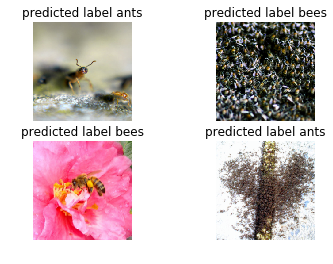

In [14]:
fig=plt.figure()
shown_batch=0
index=0
with torch.no_grad():
    for images, labels in dataloaders['val']:
        if shown_batch==1:
            break
        shown_batch +=1
        images=Variable(images)
        labels=Variable(labels)
        
        if torch.cuda.is_available():
            images=images.cuda()
            labels=labels.cuda()
        output=model_conv(images)
        _,predict= torch.max(output, 1)
        for i in range(4):
            index +=1
            ax=plt.subplot(2,2,index)
            ax.axis('off')
            ax.set_title('predicted label {}'.format(class_names[predict[i]]))
            input_img=images.cpu().data[i]
            inp=input_img.numpy().transpose((1,2,0))
            mean=np.array([0.485,0.456,0.406])
            std=np.array([0.229,0.224,0.225])
            inp=std *inp+mean
            #inp=np.clip(inp,0,1)
            plt.imshow(inp)
        

### Testing Single Image

In [30]:
from scipy.misc import imread, imresize

In [31]:
def testImage(image):
    img=imread(image)
    img=imresize(img,(512,512))
    img=img.transpose(2,0,1)
    img=img/255
    img=torch.FloatTensor(img).cuda()
    normalize=transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
    transform=transforms.Compose([normalize])
    img=transform(img)
    return img

In [32]:
path='E:/testimg/imk/cr.jpg'
img=testImage(path)

C:\Users\admin\Anaconda3\envs\pyt\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
C:\Users\admin\Anaconda3\envs\pyt\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [33]:
print(img.shape)
testImg=img.unsqueeze(0)

torch.Size([3, 512, 512])


In [34]:
output=model_conv(testImg)
_,predict= torch.max(output, 1)

RuntimeError: size mismatch, m1: [1 x 51200], m2: [512 x 2] at c:\programdata\miniconda3\conda-bld\pytorch_1533094653504\work\aten\src\thc\generic/THCTensorMathBlas.cu:249

In [24]:
predict
class_names[predict]

'bees'